# Analysis of EhV data using SCIP and IDEAS features

In [1]:
# %load common_.py
from common import *

In [2]:
import fcsparser
from ehv import feature_comparison, core
import shap
shap.initjs()

In [36]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

# Data import

In [3]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [4]:
df_scip = pq.read_table(data_dir / f"results/scip/202111241107/features.parquet").to_pandas()
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip = df_scip[numpy.load(data_dir / "results/scip/202111241107/columns.npy", allow_pickle=True)]
df_scip.shape

(142451, 407)

In [5]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(126014, 407)

In [6]:
df_scip = df_scip.drop(columns=df_scip.filter(regex="(2|5)$"))
df_scip.shape

(126014, 323)

In [7]:
# ideas features
tmp = []
for p in Path(data_dir / "results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

In [8]:
df_ideas = df_ideas.drop(columns=df_ideas.filter(regex=".*(mcp|ch4).*").columns)
df_ideas.shape

(144421, 157)

In [9]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])

In [10]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group", "meta_type"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)
df.shape

(125399, 472)

In [11]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

In [12]:
df.head()

meta_bbox_minr  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                 16.0   
2840               1              0          Ctrl                 19.0   
5782               1              0          Ctrl                 10.0   
2335               1              0          Ctrl                 12.0   
17926              1              0          Ctrl                 17.0   

                                                        meta_bbox_minc  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                  9.0   
2840               1              0          Ctrl                 12.0   
5782               1              0          Ctrl                  9.0   
2335               1              0          Ctrl                 10.0   
17926              1              0          Ctrl                 11.0   

                                                        meta_bbox_maxr  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                 28.0   
2840               1              0          Ctrl                 38.0   
5782               1              0          Ctrl                 21.0   
2335               1              0          Ctrl                 25.0   
17926              1              0          Ctrl                 29.0   

                                                        meta_bbox_maxc  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                 19.0   
2840               1              0          Ctrl                 29.0   
5782               1              0          Ctrl                 20.0   
2335               1              0          Ctrl                 21.0   
17926              1              0          Ctrl                 26.0   

                                                        meta_regions_0  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                  1.0   
2840               1              0          Ctrl                  1.0   
5782               1              0          Ctrl                  1.0   
2335               1              0          Ctrl                  1.0   
17926              1              0          Ctrl                  1.0   

                                                        meta_regions_1  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                  1.0   
2840               1              0          Ctrl                  2.0   
5782               1              0          Ctrl                  0.0   
2335               1              0          Ctrl                  1.0   
17926              1              0          Ctrl                  1.0   

                                                        meta_regions_3  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                  1.0   
2840               1              0          Ctrl                  1.0   
5782               1              0          Ctrl                  1.0   
2335               1              0          Ctrl                  1.0   
17926              1              0          Ctrl                  1.0   

                                                        meta_regions_4  \
meta_object_number meta_replicate meta_group meta_type                   
21519              1              0          Ctrl                  1.0   
2840               1              0          Ctrl                  1.0   
5782               1              0          Ctrl                  1.0   
2335               1              0          Ctrl    

# Feature comparison between IDEAS and SCIP

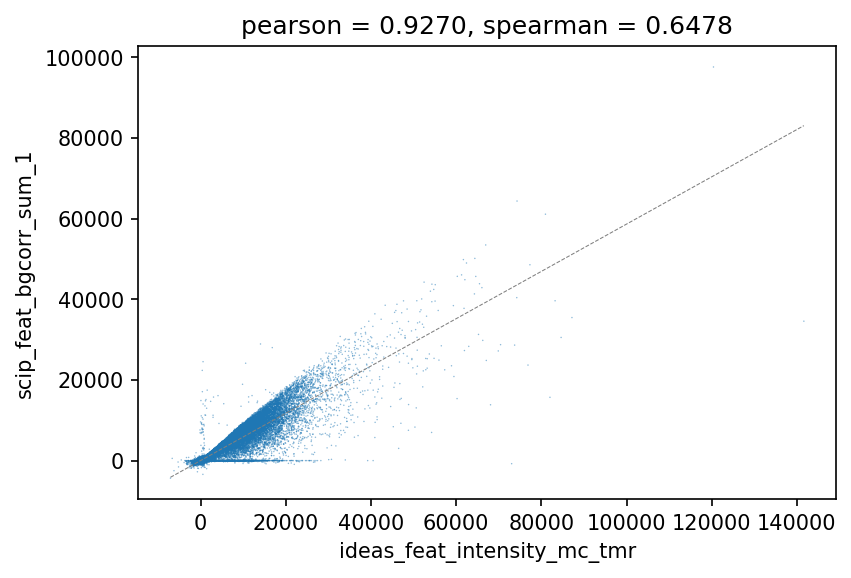

In [13]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")

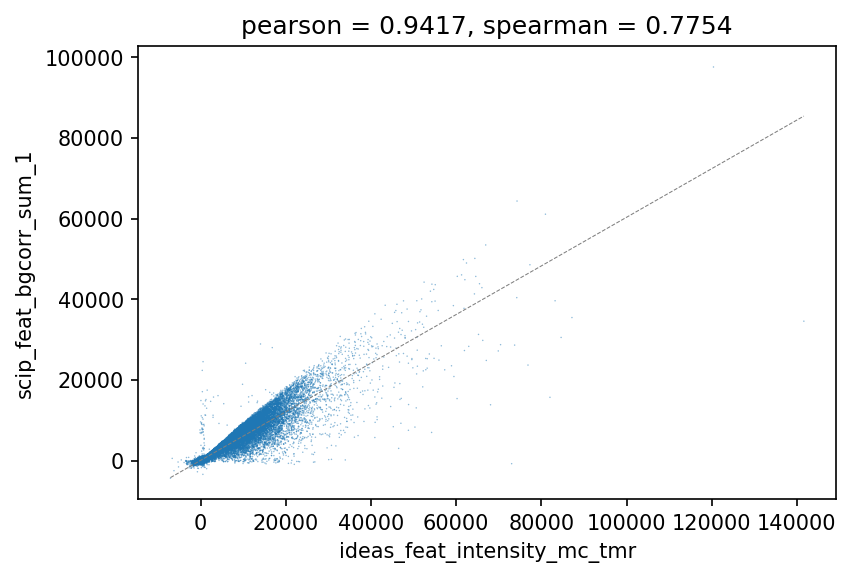

In [14]:
sel1 = df["scip_feat_bgcorr_sum_1"] == 0
sel2 = df["ideas_feat_intensity_mc_tmr"] != 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")

In [15]:
df = df[~(sel1 & sel2)]
df.shape

(92834, 472)

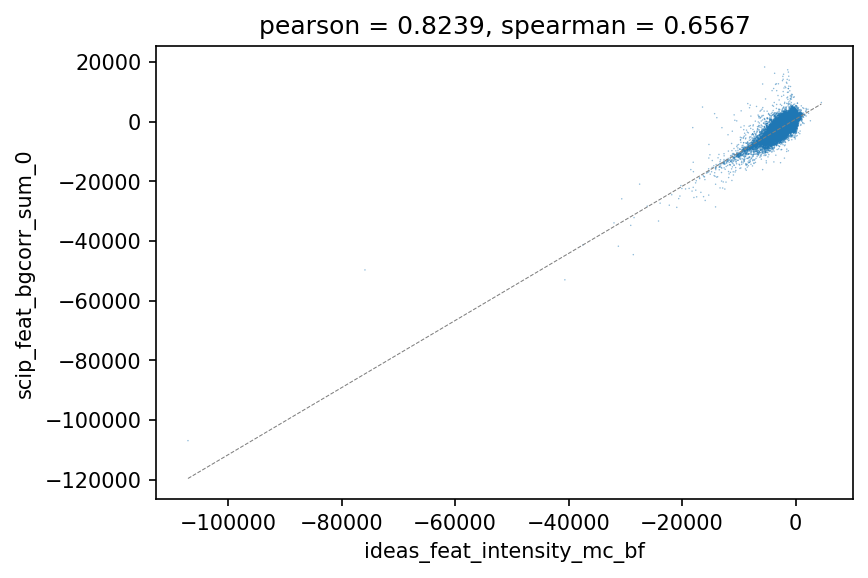

In [16]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_bf", "scip_feat_bgcorr_sum_0")

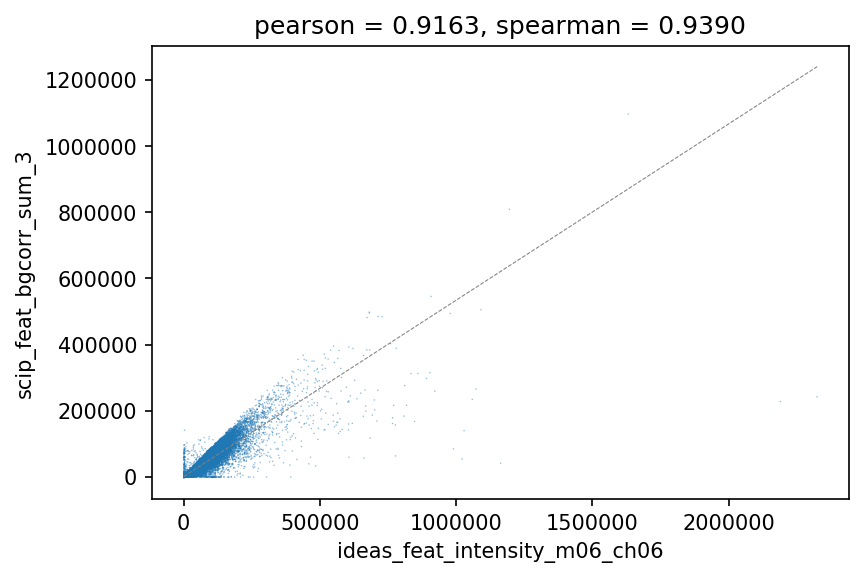

In [17]:
feature_comparison.compare_features(df, "ideas_feat_intensity_m06_ch06", "scip_feat_bgcorr_sum_3")

In [18]:
# df["meta_path"] = df["meta_path"].apply(lambda p: f"sftp://vsc42015@login.hpc.ugent.be:{p}")

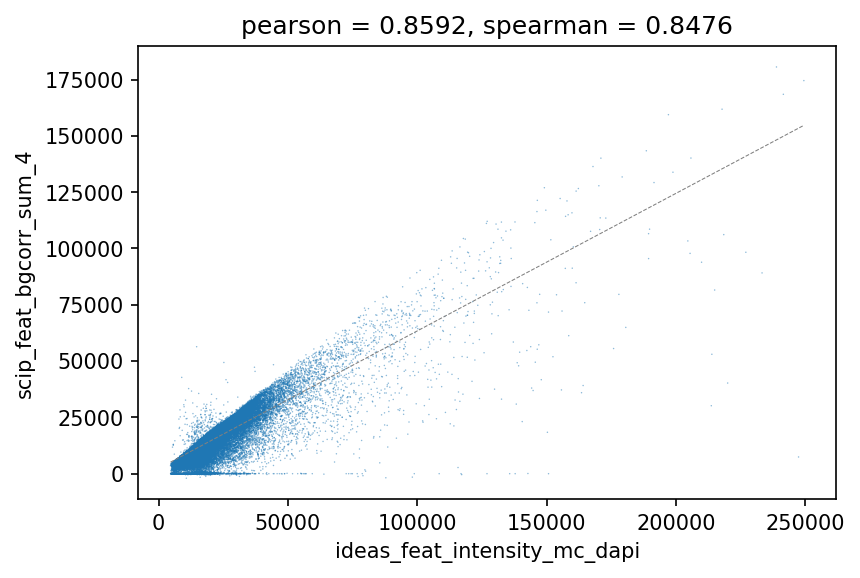

In [19]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_4")

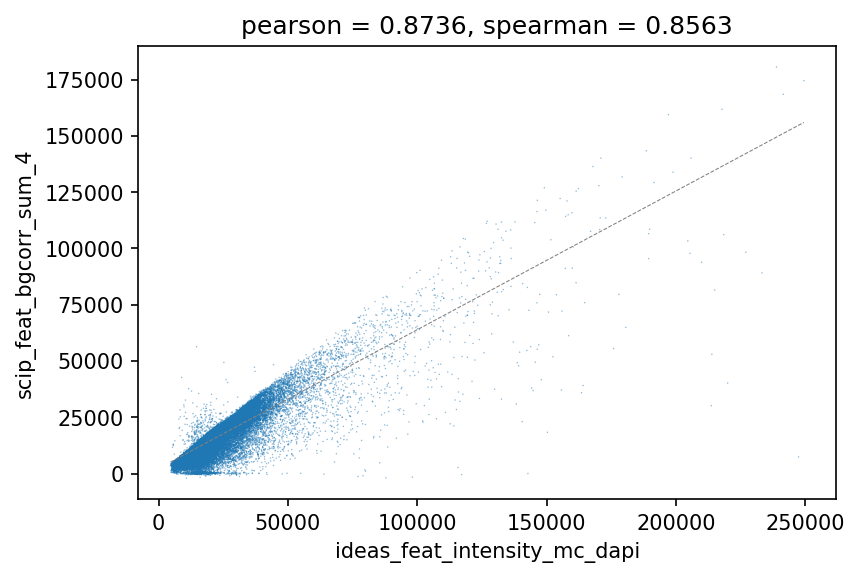

In [20]:
sel1 = df["ideas_feat_intensity_mc_dapi"] != 0
sel2 = df["scip_feat_bgcorr_sum_4"] == 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_4")

In [21]:
df = df[~(sel1 & sel2)]
df.shape

(91862, 472)

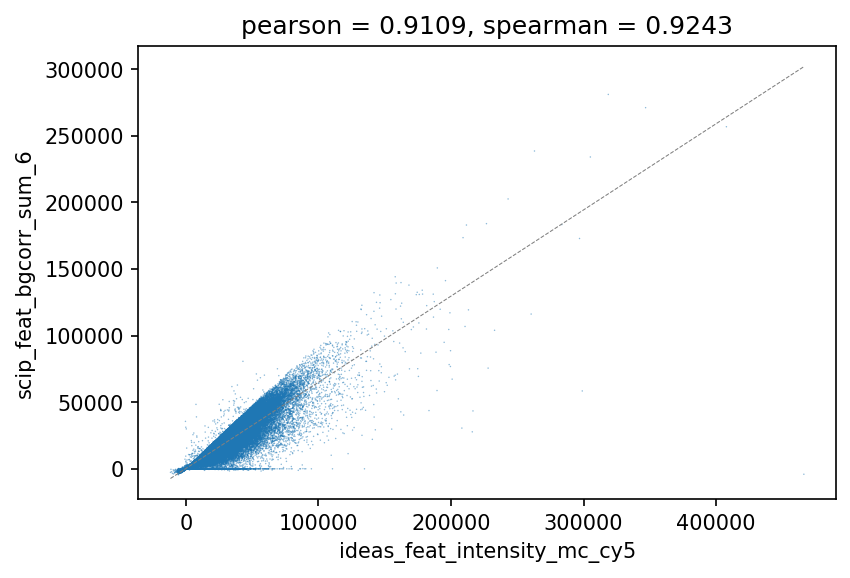

In [22]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_cy5", "scip_feat_bgcorr_sum_6")

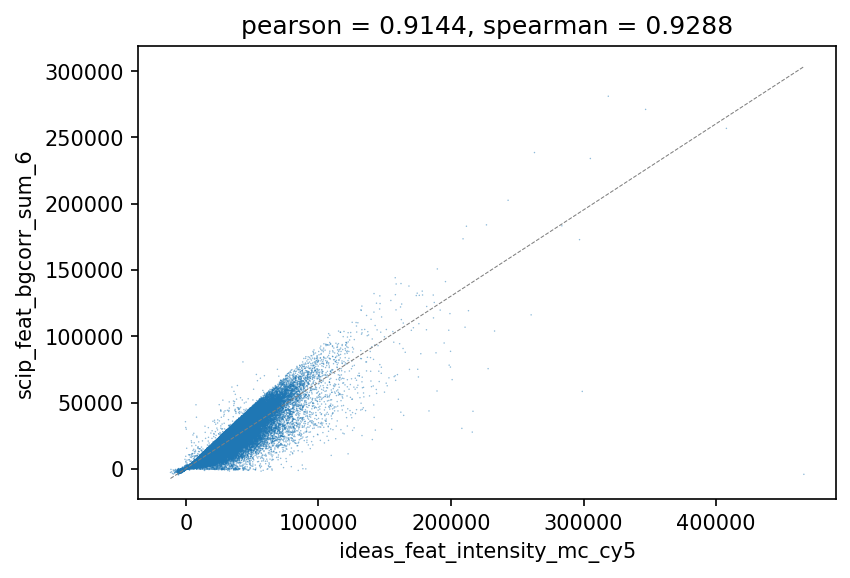

In [23]:
sel1 = df["ideas_feat_intensity_mc_cy5"] != 0
sel2 = df["scip_feat_bgcorr_sum_6"] == 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_cy5", "scip_feat_bgcorr_sum_6")

In [24]:
df = df[~(sel1 & sel2)]
df.shape

(88194, 472)

# Cloud of images

In [25]:
import zarr
import skimage
from scipy.stats import truncnorm

In [26]:
paths = numpy.random.choice(df.loc[:,:,:,"Inf"]["meta_path"].unique(), size=10)
paths

array(['/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T7_R2.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T3_R2_32.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T2_R1.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T5_R2.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T4_R3.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T5_R3_30.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T2_R3_39.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T2_R3_39.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T5_R3_36.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T9_R3.zarr'],
      dtype=object)

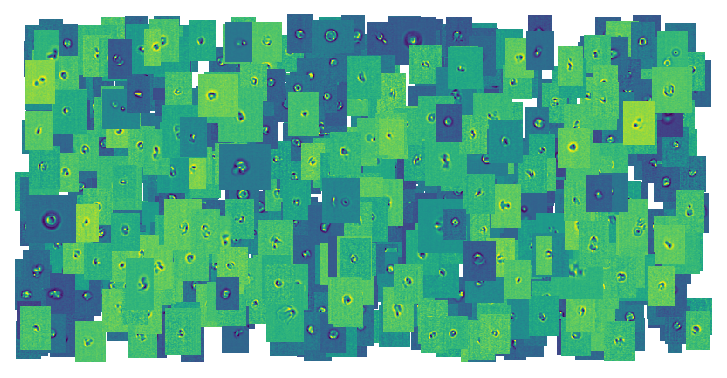

In [27]:
rows = df[df["meta_path"].isin(paths) & df["scip_feat_max_0"].between(740,750) & (df["scip_feat_area_0"] > 10)].sample(n=800)
cloud = numpy.zeros(shape=(400, 800, 4), dtype='float')
for path, gdf in rows.groupby("meta_path"):
    z = zarr.open(path)
    for idx, row in gdf.iterrows():
        img = numpy.clip(z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])[0], a_min=0, a_max=4096)
        ax, bx = 0, cloud.shape[0] - img.shape[0]
        ay, by = 0, cloud.shape[1] - img.shape[1]
        locx, scalex = cloud.shape[0] / 2, 300
        locy, scaley = cloud.shape[1] / 2, 300
        # i = int(truncnorm.rvs((ax - locx) / scalex, (bx - locx) / scalex, locx, scalex))
        # j = int(truncnorm.rvs((ay - locy) / scaley, (by - locy) / scaley, locy, scaley))
        i = numpy.random.choice(bx)
        j = numpy.random.choice(by)
        mins = img.min()
        maxs = img.max()
        img = plt.get_cmap("viridis")((img - mins) / (maxs - mins))
        
        # dist = numpy.sqrt((cloud.shape[0]/2 - i)**2 + (cloud.shape[1]/2 - j)**2) / numpy.sqrt((cloud.shape[0]/2)**2 + (cloud.shape[1]/2)**2)
        # img[..., 3] = 1 - numpy.log2(1+dist)
        
        cloud[
            i:i+img.shape[0],
            j:j+img.shape[1]
        ] = img
        
fig, ax = plt.subplots(dpi=150)
ax.set_axis_off()
ax.imshow(cloud)
plt.savefig("cloud.png", transparent=True)

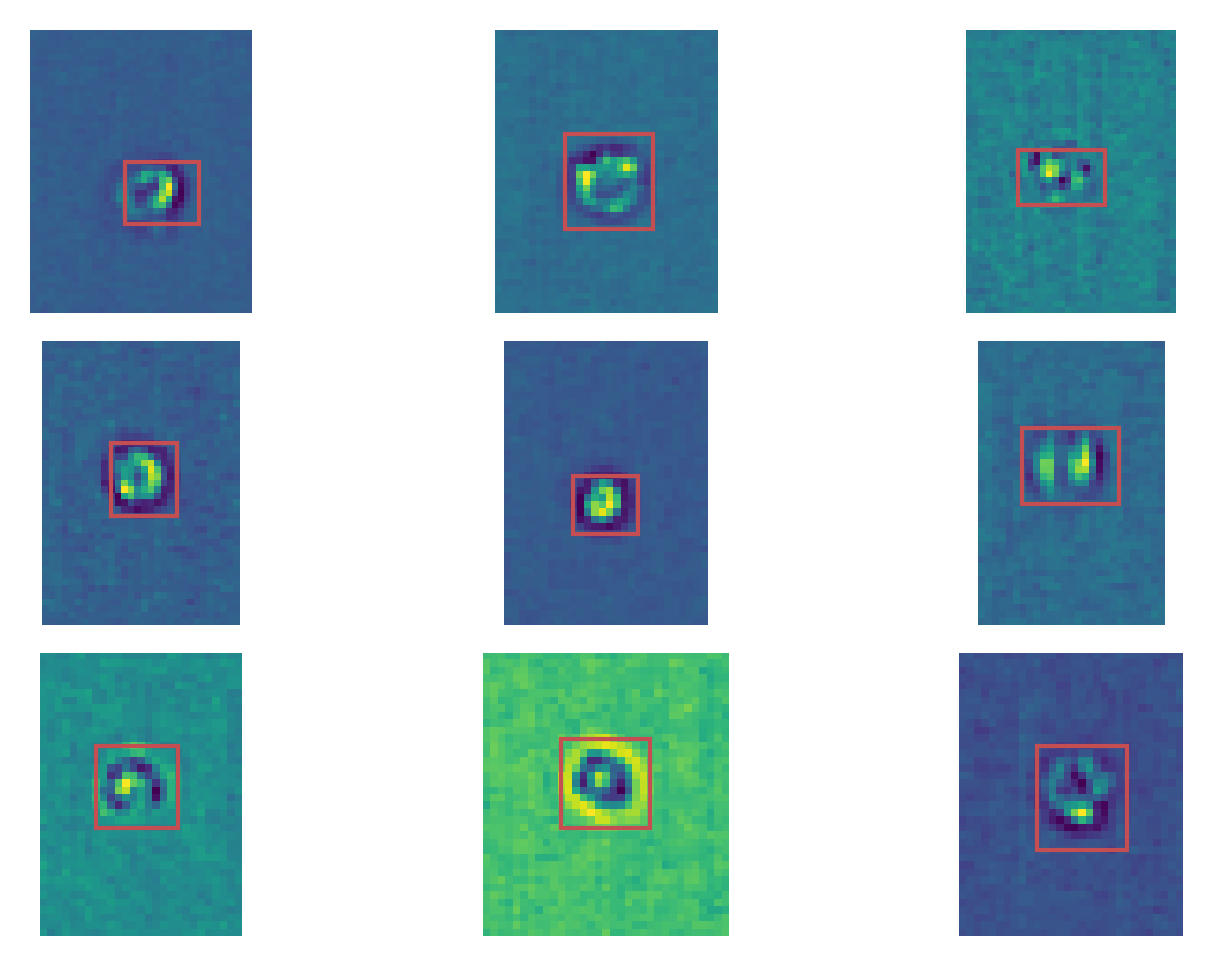

In [227]:
from matplotlib import patches
# fig, axes = plt.subplots(3, 3, dpi=300, gridspec_kw=dict(wspace=1, hspace=1), constrained_layout=True)
# axes = axes.ravel()

fig = plt.figure()
spec = fig.add_gridspec(3,3, wspace=0, hspace=0.1)

for (_, row), s in zip(rows.iterrows(), spec):
    ax = fig.add_subplot(s)
    
    minr, minc, maxr, maxc = row.filter(regex="meta_bbox")
    rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr, linewidth=1, edgecolor='r', facecolor='none')
    ax.set_axis_off()
    
    z = zarr.open(row.meta_path)
    img = z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])
    ax.imshow(plt.get_cmap("viridis")(skimage.img_as_ubyte((img[0] - img[0].min()) / (img[0].max() - img[0].min()))))
    ax.add_patch(rect)
plt.savefig("bboxes.png", dpi=300, transparent=True)

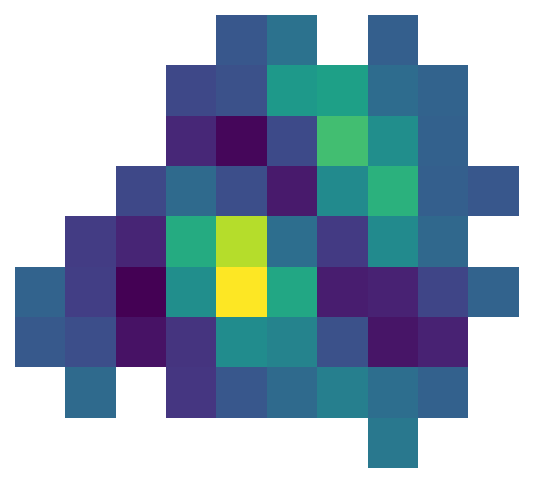

In [129]:
from scip.segmentation import threshold
fig, ax = plt.subplots(dpi=150)
row = rows.iloc[10]

z = zarr.open(row.meta_path)
el = threshold.get_mask(dict(pixels=z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])), main=True, main_channel=0)

minr, minc, maxr, maxc = row.filter(regex="meta_bbox")
img = el["pixels"][0, int(minr):int(maxr), int(minc):int(maxc)]
mask = el["mask"][0, int(minr):int(maxr), int(minc):int(maxc)]

img = skimage.img_as_float(img * mask)
img[mask] = (img[mask] - img[mask].min()) / (img[mask].max() - img[mask].min())
img = plt.get_cmap("viridis")(img)
img[~mask, 3] = 0

ax.imshow(img)
ax.set_axis_off()
plt.savefig("masked_cell.png", dpi=150, transparent=True)

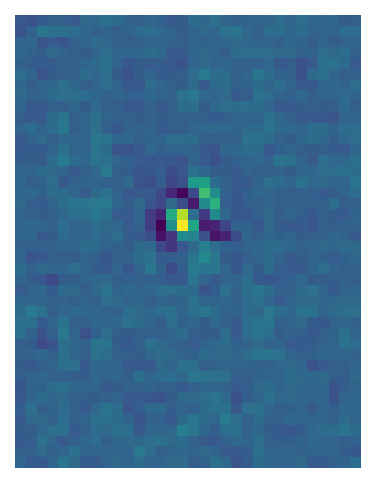

In [132]:
from scip.segmentation import threshold
fig, ax = plt.subplots(dpi=150)
row = rows.iloc[10]

z = zarr.open(row.meta_path)
img = z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])[0]

img = skimage.img_as_float(img)
img = (img - img.min()) / (img.max() - img.min())
img = plt.get_cmap("viridis")(img)

ax.imshow(img)
ax.set_axis_off()
plt.savefig("cell2.png", dpi=150, transparent=True)

# Predicting IDEAS manual gates from all fluorescence intensity features

This is a baseline sanity check. Training metrics should all be very high, since the manual gates have been set on the fluorescence intensity features using relatively simple rules.

In [85]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(42)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_results

In [226]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

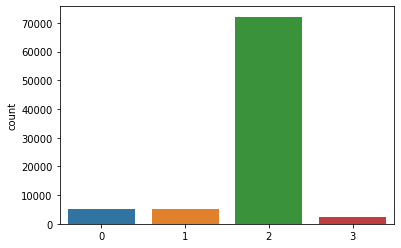

In [227]:
seaborn.countplot(x=y)

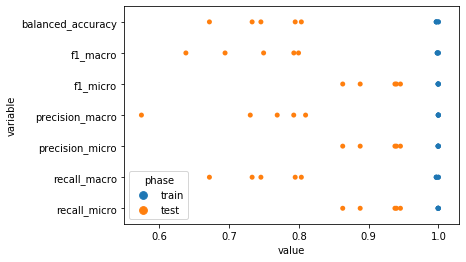

In [213]:
model = tree.DecisionTreeClassifier()
predict_gates(
    df.filter(regex="scip_feat.*bgcorr.*sum.*"), y, 
    model
)

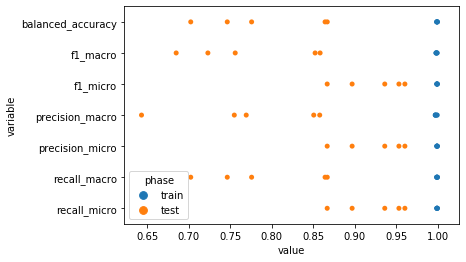

In [214]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
predict_gates(
    df.filter(regex="ideas_feat_intensity_m.*"), y, 
    model
)

# Continue with events falling in cell states

Previously, unknown events falling between gates were also present.

In [25]:
df = df[df["meta_label"] != "unknown"]
df.shape

(85192, 472)

# QC plots of control and infected samples

In [180]:
import flowutils
seaborn.set(rc={"figure.dpi":300, 'savefig.dpi':300})
seaborn.set_context("paper")
seaborn.set_style("white")

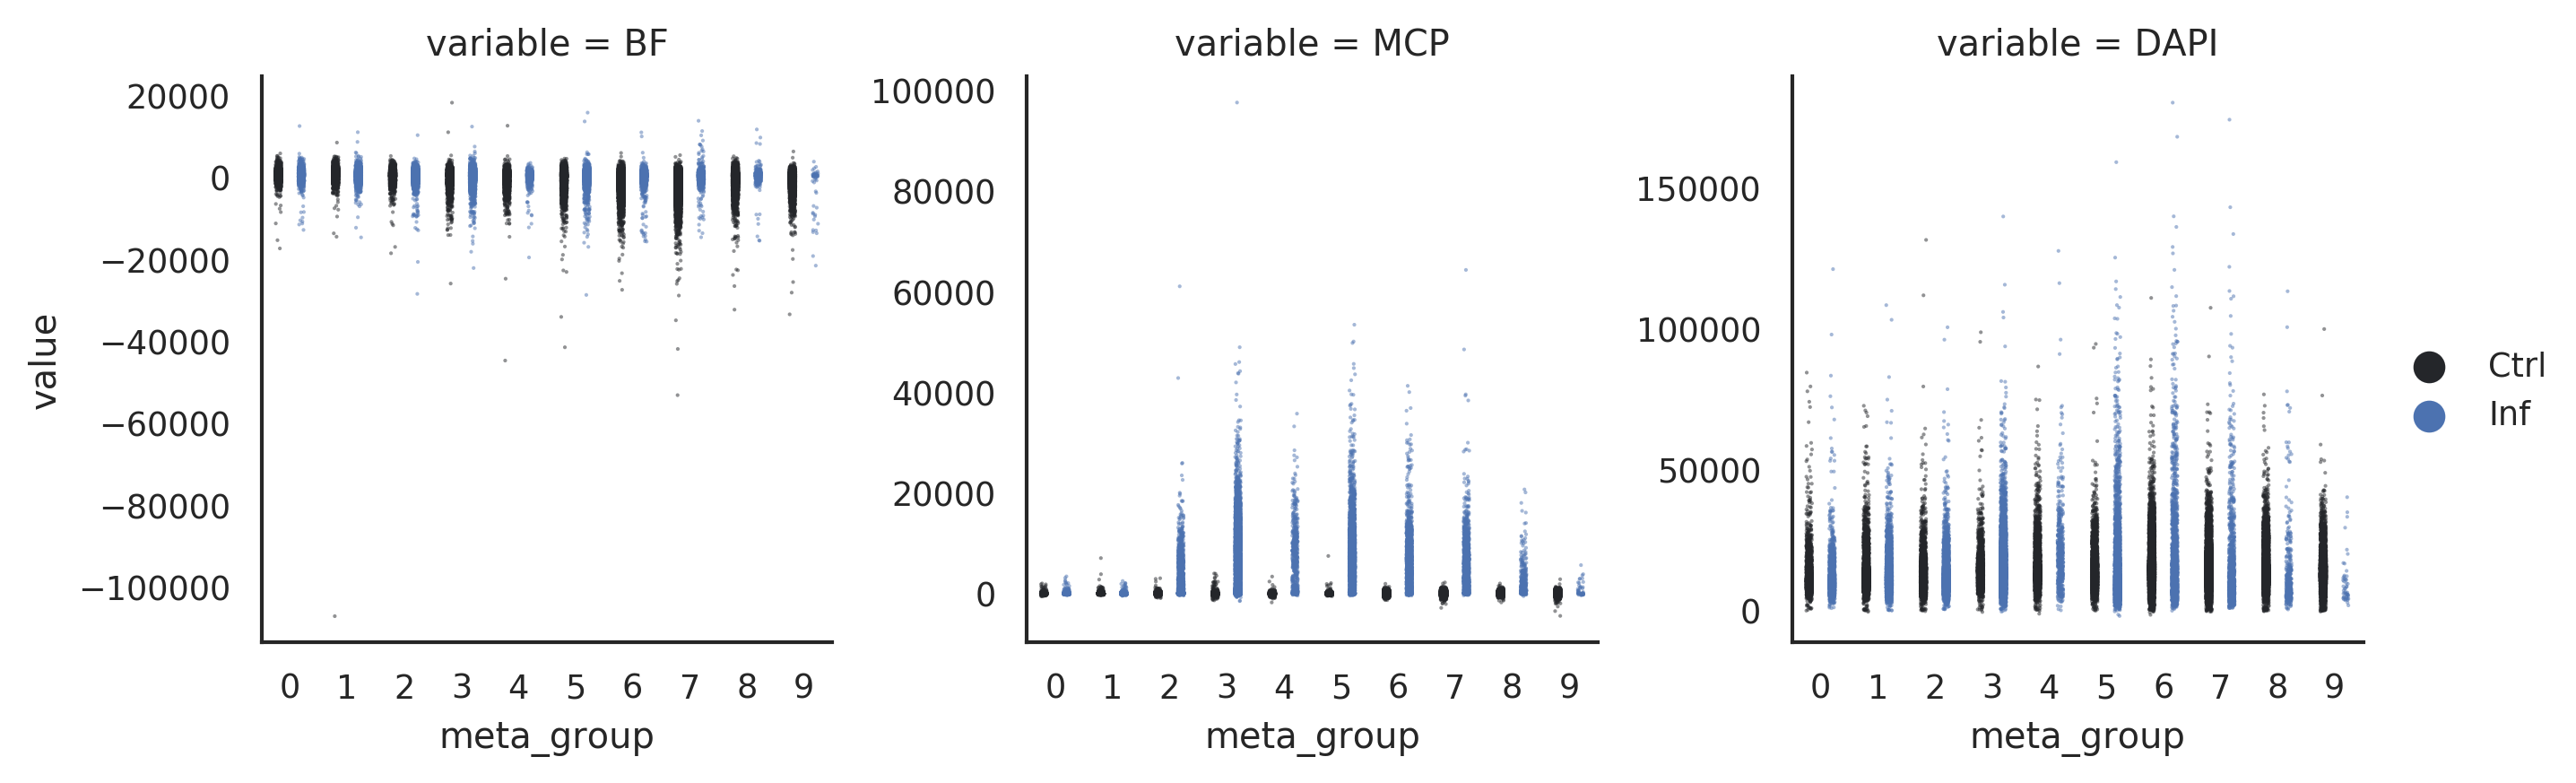

In [182]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_[0,1,4]").columns)
melted_df["variable"] = melted_df["variable"].apply(lambda p: {"scip_feat_bgcorr_sum_0": "BF", "scip_feat_bgcorr_sum_1": "MCP", "scip_feat_bgcorr_sum_4": "DAPI"}[p])
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()
plt.savefig("qc.png", transparent=True)

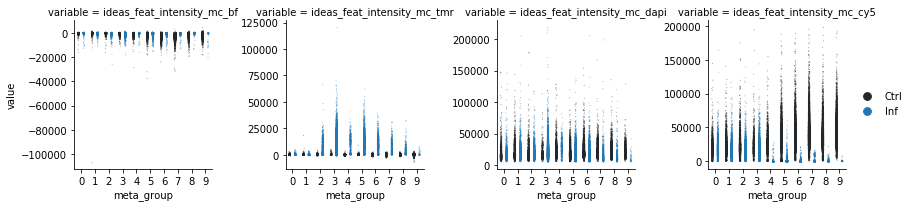

In [218]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="ideas_feat_intensity_mc").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

## Logicle transform

In [96]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[["scip_feat_bgcorr_sum_1", "scip_feat_bgcorr_sum_4", "scip_feat_bgcorr_sum_6"]]
    transf = flowutils.transforms.logicle(gdf.values, w=1, channel_indices=None)
    df.loc[(slice(None), slice(None), k, slice(None)), ["scip_feat_bgcorr_sum_logicle_1", "scip_feat_bgcorr_sum_logicle_4", "scip_feat_bgcorr_sum_logicle_6"]] = transf


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


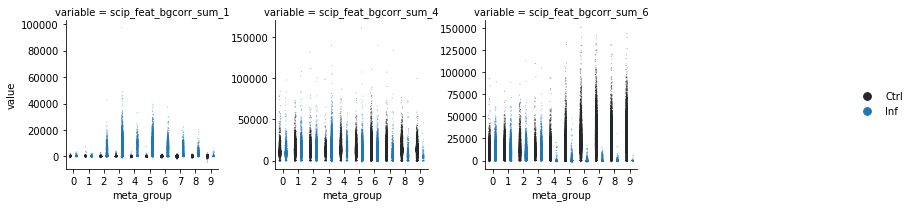

In [97]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_[1,4,6]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

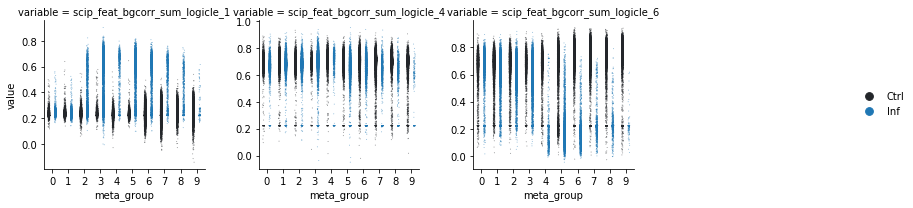

In [98]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_logicle_[0-9]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

# Clustering of events in infected samples

In [28]:
X = df.loc[:, :, :, "Inf"].filter(regex="scip_feat")
enc = LabelEncoder().fit(df["meta_label"])
enc.fit(df.loc[:, :, :, "Inf"]["meta_label"])
y = enc.transform(df.loc[:, :, :, "Inf"]["meta_label"])

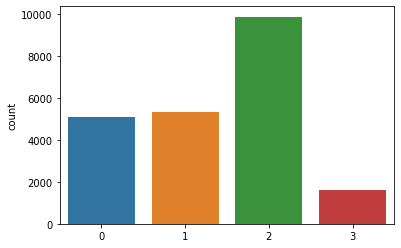

In [29]:
seaborn.countplot(x=y)

In [45]:
idx, _ = train_test_split(numpy.arange(len(X)), test_size=0.5, stratify=y)

In [46]:
X = X.iloc[idx].values
y = y[idx]
cols = df.filter(regex="scip_feat").columns.values

In [47]:
v = VarianceThreshold().fit(X)
X = v.transform(X)

In [48]:
cols = cols[v.get_support()]

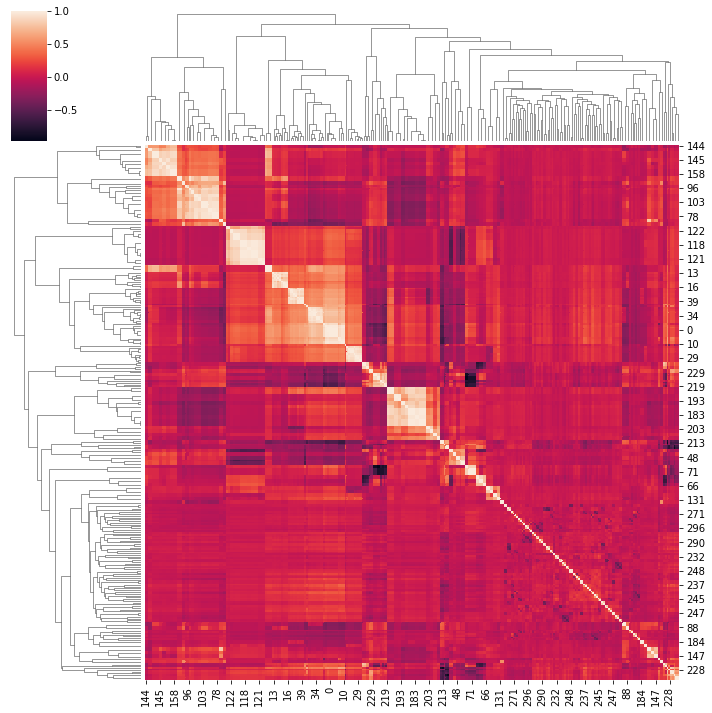

In [49]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

In [50]:
class Correlation():
    def __init__(self, thresh):
        self.thresh = thresh
    
    def fit(self, X):
        correlation = numpy.corrcoef(X, rowvar=False)
        var = X.var(axis=1)
        drop = set()
        for i in range(correlation.shape[0]):
            for j in range(i):
                if abs(correlation[i, j]) > self.thresh:
                    if var[i] >= var[j]:
                        c = i
                    else:
                        c = j
                    drop.add(c)
                    
        self.drop = list(drop)
        return self
        
    def transform(self, X, axis=1):
        return numpy.delete(X, self.drop, axis=axis)

In [51]:
corr = Correlation(0.9).fit(X)
X = corr.transform(X)
X.shape

(10949, 140)

In [52]:
cols = corr.transform(cols, axis=0)
len(cols)

140

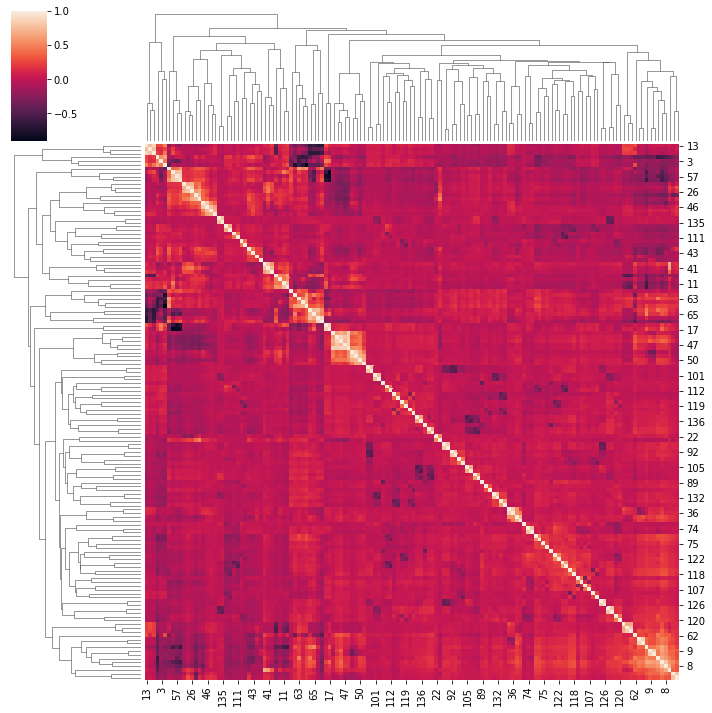

In [53]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

# Prediction of cell states based on all channels except MCP and PSBA channel

We don't use features derived from channel indices 1, 2 and 6 (which correspond to TMR and PSBA)

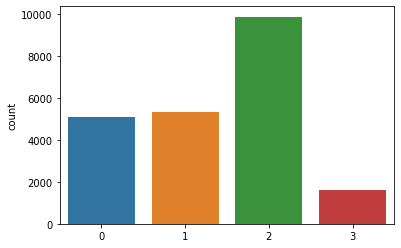

In [30]:
enc = LabelEncoder().fit(df.loc[:, :, :, "Inf"]["meta_label"])
y = enc.transform(df.loc[:, :, :, "Inf"]["meta_label"])
seaborn.countplot(x=y)

## Baseline decision-tree classifier with SCIP and IDEAS features

In [66]:
to_keep = df.filter(regex=".*scip.*[0,3,4]$").columns
Xs = df.loc[:, :, :, "Inf"][to_keep]
Xs.shape

(21898, 223)

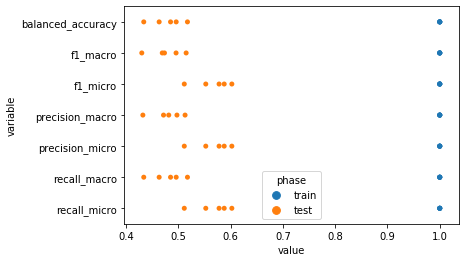

In [37]:
predict_gates(Xs, y, tree.DecisionTreeClassifier())

In [67]:
to_keep = df.filter(regex=".*ideas.*(m01|bf|m06|ch06|m07|dapi).*").columns
to_keep = numpy.array([f for f in to_keep if not (("tmr" in f) or ("cy5" in f))]) # filter out similarity features with fluorescence channels
Xi = df.loc[:, :, :, "Inf"][to_keep]
Xi.shape

(21898, 144)

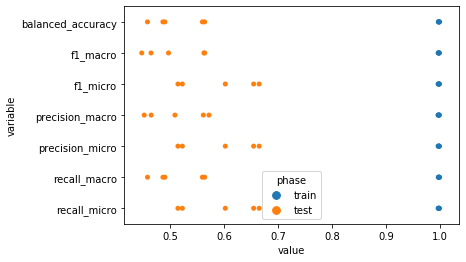

In [38]:
predict_gates(Xi, y, tree.DecisionTreeClassifier())

Two observations from the above plots:
- SCIP and IDEAS features show similar performance with a slight advantage for IDEAS. This could be due to better masks or better features being computed by IDEAS.
- The decision trees are strongly overfitting on the training data, they would need to be pruned

### Analyzing features

In [68]:
ideas_tree = tree.DecisionTreeClassifier().fit(Xi, y)
scip_tree = tree.DecisionTreeClassifier().fit(Xs, y)

In [69]:
s = numpy.argsort(ideas_tree.feature_importances_)
ideas_features = Xi.columns[s[-20:][::-1]]

In [70]:
s = numpy.argsort(scip_tree.feature_importances_)
scip_features = Xs.columns[s[-20:][::-1]]

In [71]:
pandas.DataFrame(list(zip(ideas_features, scip_features)))

0  \
0   ideas_feat_bright detail intensity r3_m07_dapi   
1           ideas_feat_minor axis intensity_m01_bf   
2                 ideas_feat_raw mean pixel_m01_bf   
3                     ideas_feat_intensity_mc_dapi   
4                       ideas_feat_circularity_m01   
5                   ideas_feat_modulation_m07_dapi   
6            ideas_feat_h variance mean_m07_dapi_5   
7             ideas_feat_spot intensity max_m01_bf   
8                    ideas_feat_intensity_m06_ch06   
9     ideas_feat_bright detail intensity r7_m01_bf   
10                    ideas_feat_contrast_m07_dapi   
11           ideas_feat_h contrast mean_m07_dapi_5   
12              ideas_feat_raw median pixel_m01_bf   
13                       ideas_feat_std dev_m01_bf   
14                ideas_feat_gradient max_m07_dapi   
15                    ideas_feat_symmetry 3_m01_bf   
16          ideas_feat_h homogeneity mean_m01_bf_5   
17                  ideas_feat_mean pixel_m06_ch06   
18               ideas_feat_h energy mean_m01_bf_5   
19                  ideas_feat_median pixel_m01_bf   

                                          1  
0                    scip_feat_bgcorr_var_4  
1             scip_feat_minor_axis_length_0  
2                          scip_feat_mean_0  
3             scip_feat_minor_axis_length_4  
4                           scip_feat_min_0  
5                           scip_feat_max_0  
6                      scip_feat_skewness_0  
7                           scip_feat_max_4  
8                    scip_feat_bgcorr_max_0  
9                    scip_feat_bgcorr_sum_0  
10                   scip_feat_bgcorr_mad_0  
11                     scip_feat_edge_var_4  
12                  scip_feat_bgcorr_mean_0  
13                   scip_feat_bgcorr_sum_4  
14                  scip_feat_convex_area_0  
15                   scip_feat_bgcorr_sum_3  
16                     scip_feat_kurtosis_4  
17  scip_feat_bgcorr_glcm_dissimilarity_5_0  
18                          scip_feat_mad_0  
19                   scip_feat_bgcorr_min_4

In [76]:
s = numpy.argsort(scip_tree.feature_importances_)
scip_features = Xs.columns[s[::-1]]
scip_features.to_list().index("scip_feat_eccentricity_0")

54

The list above shows the most important features used by the decision tree to make its classification. In the SCIP features we see more basic features like mean, min, minor axis length or skewness. In the IDEAS column, we see more complex features like bright detail intensity, minor axis intensity or circularity. This likely confirms the hypothesis that IDEAS features are currently better. For now I will continue using the SCIP features, while I also work on improving the features

## Handling class imbalance

In [79]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline

In [ ]:
make_pipeline(
    RandomOverSampler(sampling_strategy="not majority"),
    tree.DecisionTreeClassifier()
)

## SHAP analysis to identify features explaining cell states

In [190]:
to_keep = df.filter(regex=".*scip.*bgcorr.*[0,3,4]$").columns
X = df.loc[:, :, :, "Inf"][to_keep]
model = XGBClassifier(use_label_encoder=False, tree_method="gpu_hist").fit(X.values, y)

[17:02:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [191]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


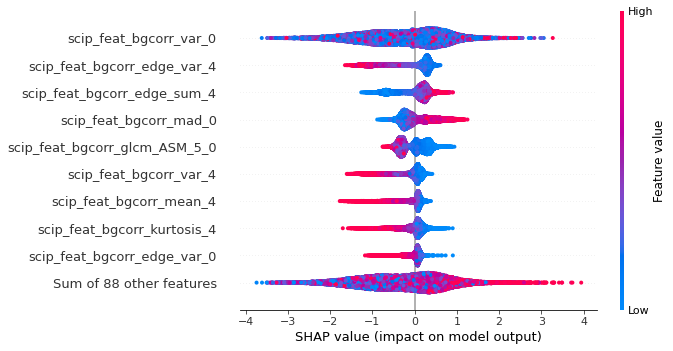

In [219]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

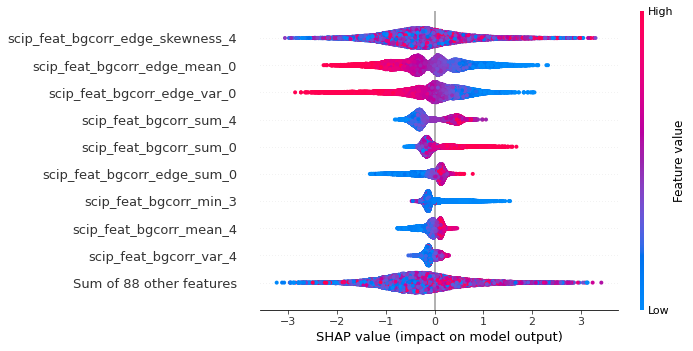

In [220]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

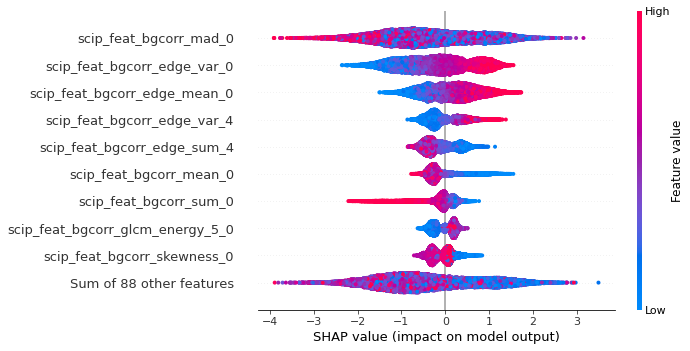

In [221]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

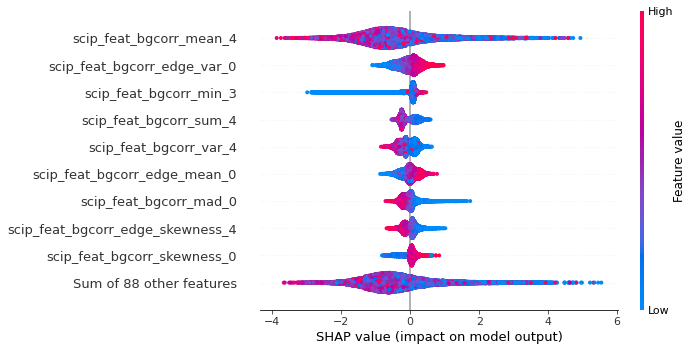

In [222]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

### BF mean edge pixel value

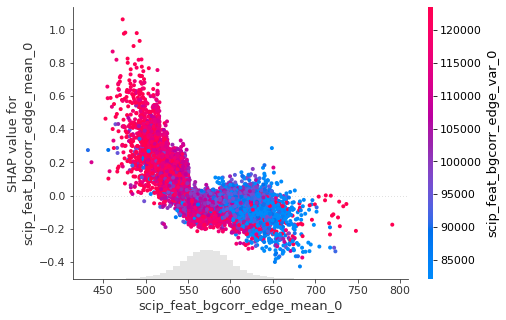

In [211]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

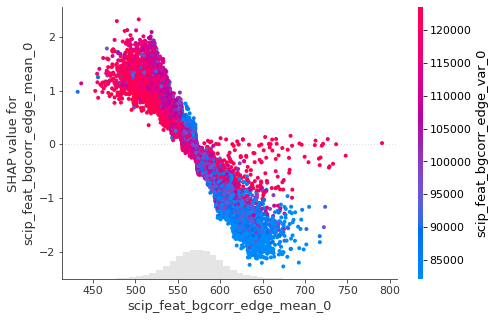

In [212]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

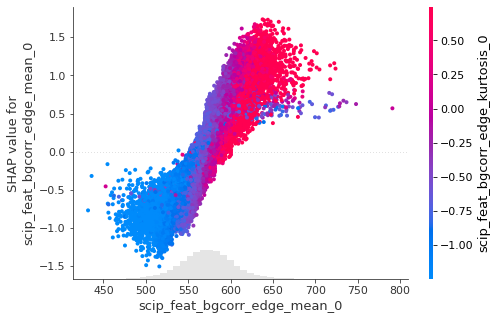

In [213]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

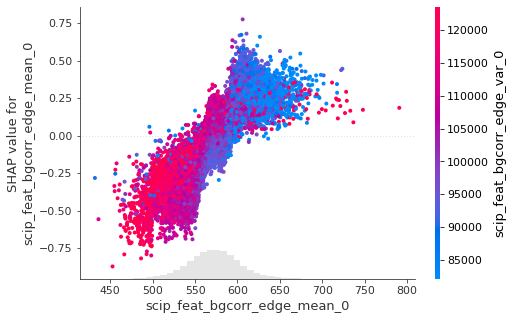

In [214]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

In [225]:
interaction = explainer.shap_interaction_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [229]:
len(interaction)

4

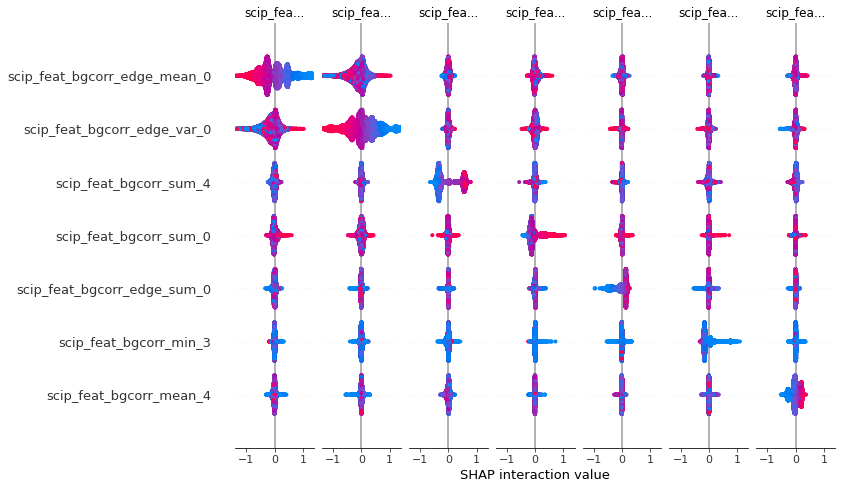

In [230]:
shap.summary_plot(interaction[0], X)

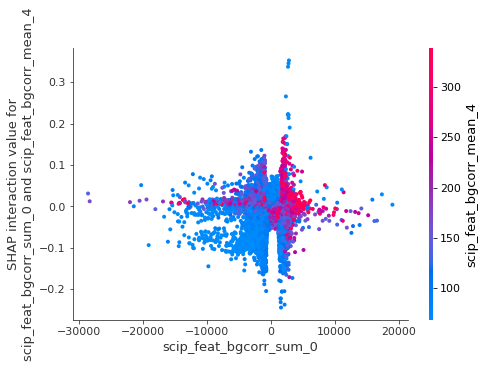

In [233]:
shap.dependence_plot(
    ("scip_feat_bgcorr_sum_0", "scip_feat_bgcorr_mean_4"),
    interaction[0], X
)

### BF intensity

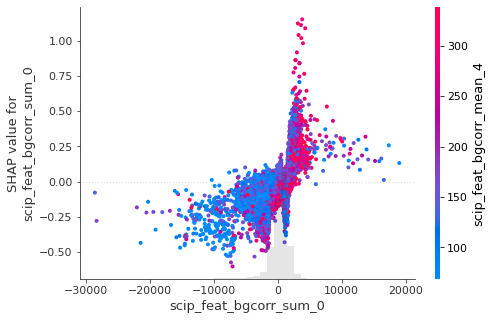

In [208]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

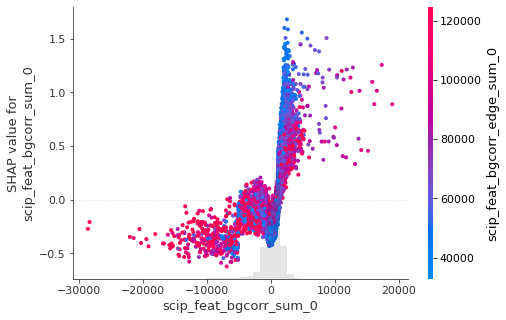

In [193]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

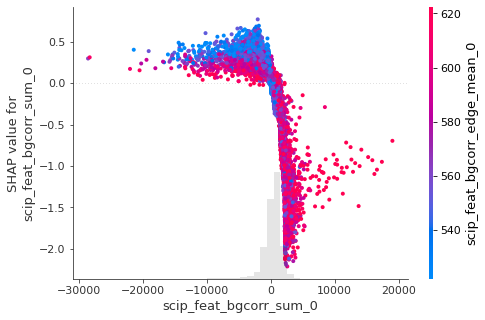

In [194]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

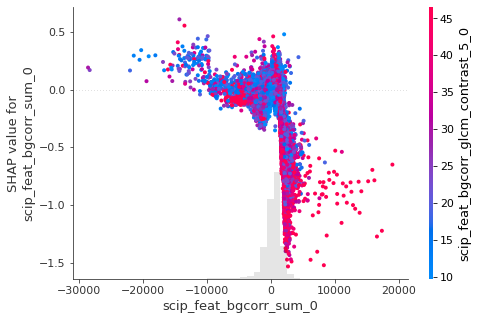

In [195]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

### DAPI intensity

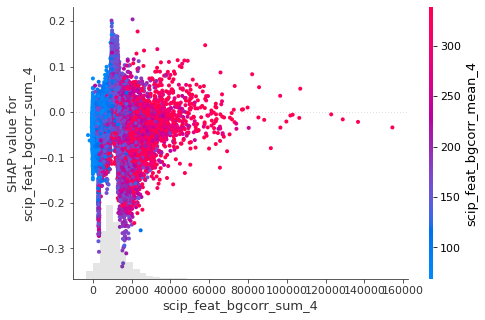

In [196]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])

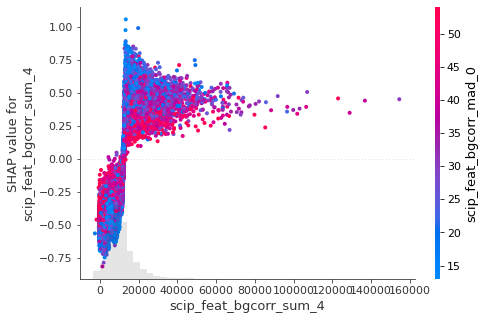

In [197]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])

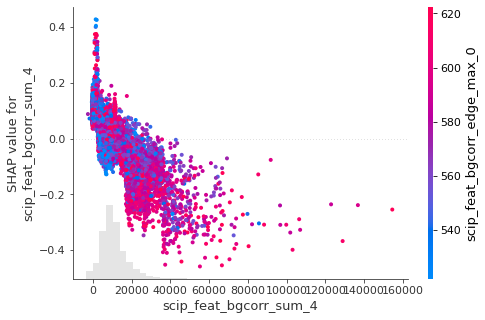

In [200]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])

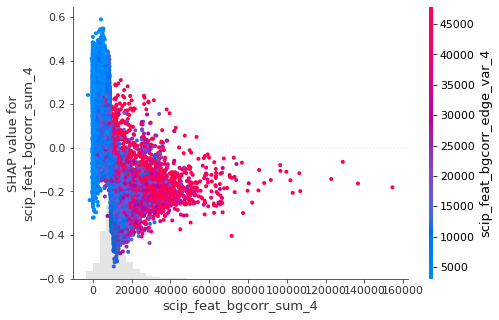

In [201]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])